GBIF CANE TOAD DATA!
GBIF.org (21 December 2022) GBIF Occurrence Download  https://doi.org/10.15468/dl.8pukaa


In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
from shapely.geometry import Point
import geopandas as gpd
from matplotlib.pyplot import hexbin
import matplotlib as mpl
import numpy as np

from shapely.geometry import Polygon, LineString, Point, MultiPoint
import rasterio
from rasterio.plot import show
matplotlib.rcParams['figure.figsize'] = 10,10
import sys
sys.path.append("../pipelines/src")
from make_biomap import *

/var/folders/hs/nkqsbzxx23bdyv2b4j6bd0zr0000gn/T/ipykernel_7102/1758141364.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
! pwd

/Users/silastittes/Documents/KR_colab_projects/spatial_sims_standard/case_studies/toads/notebooks


In [3]:
from dataclasses import dataclass

@dataclass
class ToadData:
    """
    Class for storing and plotting toad data

    gbif_file: string
        path to gbif data
    aus_border_file: string
        path to shapefile of australia
    env_file: string
        path to environmental data
    sim_locations_file: string
        path to simulated locations
    latitude_range: tuple
        range of latitudes to include
    longitude_range: tuple
        range of longitudes to include
    resolution: tuple
        resolution of environmental data
    """

    gbif_file: str
    aus_border_file: str
    env_file: str
    sim_locations_file: str
    latitude_range: tuple = (-45, -10)
    longitude_range: tuple = (110, 155) 
    resolution: tuple = (200, 200)
    img_size: int = 1000
    min_year: int =  1935
    max_year: int = 2022

    def __post_init__(self):

        #border of australia
        self.aus_border = gpd.read_file(self.aus_border_file).simplify(0.1)
        
        #get empirical data
        self.gbif_aus = pd.read_csv(self.gbif_file, sep = "\t") \
            .query("countryCode == 'AU'") \
            .query("year >= 1935") \
            .sort_values(by=['year'], ascending=False)
        
        self.env_img = rasterio.open(self.env_file)

        self.gdf = make_envmap(latitude_range = self.latitude_range, longitude_range = self.longitude_range, raster = self.env_img, shape = self.aus_border, resolution = self.resolution)

        pnt_lower_left = Point(self.longitude_range[0], self.latitude_range[0])
        pnt_lower_right = Point(self.longitude_range[1], self.latitude_range[0])
        pnt_upper_left = Point(self.longitude_range[0], self.latitude_range[1])
        pnt_upper_right = Point(self.longitude_range[1], self.latitude_range[1])

        #get width convert from m to km
        self.map_width = self.get_distance(pnt_lower_left, pnt_lower_right)[0] / 1000
        self.map_height = self.get_distance(pnt_lower_left, pnt_upper_left)[0] / 1000

        toad_init = self.gbif_aus.query("year<=1939")
        location = (toad_init["decimalLongitude"], toad_init["decimalLatitude"])
        self.map_dims = (self.longitude_range[0], self.longitude_range[1], self.latitude_range[0], self.latitude_range[1])
        self.image_dims = (0.0, self.map_width, 0.0, self.map_height)

        toad_km = scaled_location(
            location,
            self.map_dims,
            self.image_dims
        )
        toad_km  = np.array(toad_km)
        
        #get toad origin re-oriented x and y
        self.MAP_XL, self.MAP_XH = - toad_km[0][0], self.map_width - toad_km[0][0]
        self.MAP_YL, self.MAP_YH = - toad_km[1][0], self.map_height - toad_km[1][0]

        self.image_dims_adjusted = (self.MAP_XL, self.MAP_XH, self.MAP_YL, self.MAP_YH)

        #read in simulated location data, add latlong coords
        self.locations_data = pd.read_csv(self.sim_locations_file, sep = "\t")        
        if np.mean([i in self.locations_data.columns for i in ['x', 'y', 'Year']]) != 1.0:
            raise ValueError(f"{self.sims_location_file} does not have the correct columns: ['x', 'y', 'Year']")

        #add latlong to sim locations
        toad_env_long_lat = [scaled_location((row.x, row.y), self.image_dims_adjusted, self.map_dims) for row in self.locations_data.itertuples()]
        self.locations_data['long'] = [i[0] for i in toad_env_long_lat]
        self.locations_data['lat'] = [i[1] for i in toad_env_long_lat]

        my_cmap = mpl.colormaps['viridis']
        my_colors = my_cmap.colors[::-1]
        colormap_n = len(my_cmap.colors)
        years = np.arange(self.min_year, self.max_year + 1, 1)
        year_color_key = np.linspace(self.min_year, self.max_year, colormap_n)
        year_color_dict = {year:my_colors[np.searchsorted(year_color_key, year)] for year in years}
        self.year_color_dict = year_color_dict

        print(", ".join([str(round(i,1))for i in toad_km[0] - toad_km[0][0]]))
        print(", ".join([str(round(i,1))for i in toad_km[1] - toad_km[1][0]]))

    def get_distance(self, point1, point2, input_projection= "EPSG:7844", output_projection = "EPSG:3033"):
        df1 = gpd.GeoDataFrame({'geometry': [point1]}, crs=input_projection)
        df2 = gpd.GeoDataFrame({'geometry': [point2]}, crs=input_projection)
        df1 = df1.to_crs(output_projection)
        df2 = df2.to_crs(output_projection)
        return df1.distance(df2)

def toad_main_plot(ToadData, data_lat, data_long, data_year, ax, last_year = 2012, hex = True, quick = False, plot_env=True): 

    #inputs can be may be sims or real
    data_year = np.array(data_year).astype(int)
    data_select = pd.DataFrame({"long": data_long, "lat": data_lat, "Year": data_year})
    data_select = data_select.query(f"Year <= {last_year}")
    data_years = np.unique(data_select.Year, return_counts = False)[::-1]
    
    if plot_env:
        ax.scatter(ToadData.gdf.long, ToadData.gdf.lat, c = np.log(ToadData.gdf.variable), marker = 's', cmap="gray_r", s = 1.5)

    for order, year in enumerate(data_years):
        year_data = data_select.query(f"Year == {year}")
        if quick:
            year_data = year_data.query(f"Year == {year}").head(20)
        
        if hex:
            hb = ax.hexbin(year_data.long, year_data.lat, gridsize = 50, mincnt=1, bins='log', zorder = order + 1)
            hex_offsets = hb.get_offsets()
            hex_points = [Point(x[0], x[1]) for x in hex_offsets]
            border_hex_bool = np.array([not ToadData.aus_border.contains(p)[0] for p in hex_points])
            hb.get_offsets()[border_hex_bool, :] = np.array([np.nan, np.nan])
            new_color_arr = np.tile(ToadData.year_color_dict[year], (hb.get_facecolors().shape[0], 1))
            hb.set(array=None, facecolors=new_color_arr)
        else:
                #plot toads colored by time
            ax.scatter(
                year_data.long, 
                year_data.lat,
                color = ToadData.year_color_dict[year],
                s = 5
            )

    ToadData.aus_border.boundary.plot(
            ax = ax,
            edgecolor="black",
            alpha = 1,
            linewidth = 2
    )
    ax.set_xlim(ToadData.longitude_range)
    ax.set_ylim(ToadData.latitude_range)
    


Run SLiM. K adjusted to speed things up, but otherwise same settings as in the manuscript.

In [4]:
! mkdir -p ../recipes/noevn/
! cd ../recipes/; slim -s 1342 -define K=1e-1 -define ENVIRONMENTAL_FITNESS=0 -define FOUNDER_N=5000 CaneToads_RangeExpansion_Environment_Australia.slim 
! cd ../recipes/; mv locations.txt noevn/locations.txt
! cd ../recipes/; slim -s 1342 -define K=1 -define ENVIRONMENTAL_FITNESS=1 -define FOUNDER_N=5000 CaneToads_RangeExpansion_Environment_Australia.slim 

// Initial random seed:
1342

// RunInitializeCallbacks():
initializeSLiMModelType(modelType = 'nonWF');
initializeSLiMOptions(dimensionality = 'xy');
initializeSex("A");
initializeTreeSeq();
Model constants: "COL_DIM"=800;"DF"=3.0;"ENVIRONMENTAL_FITNESS"=0;"FOUNDER_N"=5000;"K"=0.1;"LANDMAP_PATH"="../pipelines/data/australia_land.png";"LIFETIME"=2.0;"MAP_PATH"="../pipelines/data/australia_bio_12.png";"MAP_XH"=271.0;"MAP_XL"=-3493.0;"MAP_YH"=2034.0;"MAP_YL"=-2865.0;"MAX_ENV"=3945.0;"MIN_ENV"=92.0;"OUTBASE"="./out_NULL";"OUTDIR"=".";"OUTPATH"="./out_NULL.trees";"PARAMFILE"="./params.json";"ROW_DIM"=800;"SD"=20.0;"SEED"=1342;"SM"=20.0;"START_X"=0.0 -457.5 -484.0 39.1 -467.2 58.6 -499.3 -481.2 50.2 -485.4 -216.2 -364.0 -464.4 -389.1 -214.8 -459.6 -490.9 -477.0 -488.1 -530.0 50.2 -468.6 58.6 -214.8 -481.2 48.8 -504.9 -499.3 -532.8 -486.8 -464.4 -388.8 -533.5 -454.7 -487.8 -475.0 41.8 -363.3 50.2 -465.1 -534.2 -504.9 -214.8 -389.1 -364.0 50.2 -467.2 -509.1 -486.8 -479.8 -486.8 -499.3 -502.1 

In [10]:
toad_data = ToadData(
    gbif_file = "../pipelines/data/cane_toads_gbif.csv",
    aus_border_file = "../pipelines/data/AUS_2021_AUST_GDA2020.shp",
    env_file = r'../pipelines/data/wc2.1_10m_bio_12.tif',
    sim_locations_file =  "../recipes/locations.txt",
)

toad_data_noenv = ToadData(
    gbif_file = "../pipelines/data/cane_toads_gbif.csv",
    aus_border_file = "../pipelines/data/AUS_2021_AUST_GDA2020.shp",
    env_file = r'../pipelines/data/wc2.1_10m_bio_12.tif',
    sim_locations_file =  "../recipes/noevn/locations.txt",
)

/Users/silastittes/opt/envs/spatial_sims/lib/python3.12/site-packages/shapely/constructive.py:862: RuntimeWarning: invalid value encountered in simplify_preserve_topology
  return lib.simplify_preserve_topology(geometry, tolerance, **kwargs)
/var/folders/hs/nkqsbzxx23bdyv2b4j6bd0zr0000gn/T/ipykernel_7102/1637788407.py:41: DtypeWarning: Columns (10,45) have mixed types. Specify dtype option on import or set low_memory=False.
  self.gbif_aus = pd.read_csv(self.gbif_file, sep = "\t") \
/Users/silastittes/opt/envs/spatial_sims/lib/python3.12/site-packages/geopandas/geodataframe.py:2377: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:7844

  return geopandas.clip(self, mask=mask, keep_geom_type=keep_geom_type)


0.0, -457.5, 39.1, -484.0, -467.2, -481.2, -499.3, -485.4, 58.6, 50.2, -534.2, -477.0, -364.0, -389.1, -214.8, -487.8, -454.7, -488.1, -363.3, 48.8, -388.8, -499.3, 50.2, -468.6, -459.6, 50.2, -465.1, -490.9, 50.2, -214.8, -216.2, -389.1, -504.9, -486.8, -504.9, 58.6, -481.2, -214.8, -364.0, -530.0, -533.5, 41.8, -467.2, -464.4, -464.4, -475.0, -532.8, -460.3, -479.8, -484.0, -509.1, -490.9, -478.4, -499.3, -502.1, -474.2, -486.8, -486.8, -499.3, -499.3
0.0, 832.9, -70.0, 811.9, 823.5, 970.5, 1042.8, 962.4, -95.7, -46.7, 1129.1, 825.9, 692.9, 702.2, 473.6, 1006.7, 776.9, 1005.5, 694.1, -56.0, 702.2, 1041.1, -46.7, 823.5, 830.5, -46.7, 794.4, 1028.8, -46.7, 473.6, 473.6, 702.2, 1034.7, 1012.5, 1052.2, -91.0, 970.5, 473.6, 695.2, 1066.2, 1129.7, -95.7, 823.5, 793.2, 793.2, 984.5, 1129.2, 832.9, 975.2, 884.2, 1068.5, 1028.8, 979.8, 1040.5, 1066.2, 828.2, 923.9, 923.8, 1040.5, 1040.5


/Users/silastittes/opt/envs/spatial_sims/lib/python3.12/site-packages/shapely/constructive.py:862: RuntimeWarning: overflow encountered in simplify_preserve_topology
  return lib.simplify_preserve_topology(geometry, tolerance, **kwargs)
/Users/silastittes/opt/envs/spatial_sims/lib/python3.12/site-packages/shapely/constructive.py:862: RuntimeWarning: invalid value encountered in simplify_preserve_topology
  return lib.simplify_preserve_topology(geometry, tolerance, **kwargs)
/var/folders/hs/nkqsbzxx23bdyv2b4j6bd0zr0000gn/T/ipykernel_7102/1637788407.py:41: DtypeWarning: Columns (10,45) have mixed types. Specify dtype option on import or set low_memory=False.
  self.gbif_aus = pd.read_csv(self.gbif_file, sep = "\t") \
/Users/silastittes/opt/envs/spatial_sims/lib/python3.12/site-packages/geopandas/geodataframe.py:2377: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the

0.0, -457.5, 39.1, -484.0, -467.2, -481.2, -499.3, -485.4, 58.6, 50.2, -534.2, -477.0, -364.0, -389.1, -214.8, -487.8, -454.7, -488.1, -363.3, 48.8, -388.8, -499.3, 50.2, -468.6, -459.6, 50.2, -465.1, -490.9, 50.2, -214.8, -216.2, -389.1, -504.9, -486.8, -504.9, 58.6, -481.2, -214.8, -364.0, -530.0, -533.5, 41.8, -467.2, -464.4, -464.4, -475.0, -532.8, -460.3, -479.8, -484.0, -509.1, -490.9, -478.4, -499.3, -502.1, -474.2, -486.8, -486.8, -499.3, -499.3
0.0, 832.9, -70.0, 811.9, 823.5, 970.5, 1042.8, 962.4, -95.7, -46.7, 1129.1, 825.9, 692.9, 702.2, 473.6, 1006.7, 776.9, 1005.5, 694.1, -56.0, 702.2, 1041.1, -46.7, 823.5, 830.5, -46.7, 794.4, 1028.8, -46.7, 473.6, 473.6, 702.2, 1034.7, 1012.5, 1052.2, -91.0, 970.5, 473.6, 695.2, 1066.2, 1129.7, -95.7, 823.5, 793.2, 793.2, 984.5, 1129.2, 832.9, 975.2, 884.2, 1068.5, 1028.8, 979.8, 1040.5, 1066.2, 828.2, 923.9, 923.8, 1040.5, 1040.5


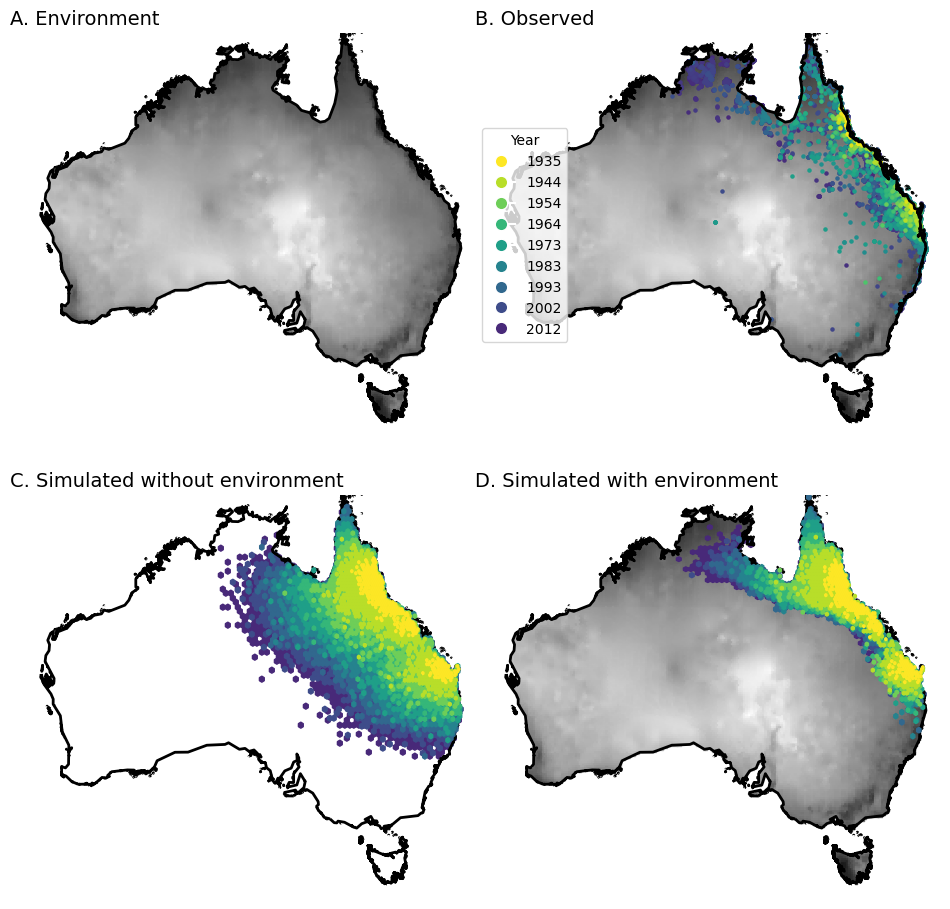

In [11]:
fig, ax = plt.subplots(2,2, figsize=(12,12))

params = {'legend.fontsize': 10,
           'legend.markerscale': 1.5, 
           'legend.handlelength': 2}
plt.rcParams.update(params)

toad_main_plot(toad_data, [], [], [], ax[0,0], hex = False)
ax[0,0].set_title("A. Environment", fontsize = 14, loc = "left")
toad_main_plot(toad_data, toad_data.gbif_aus["decimalLatitude"], toad_data.gbif_aus["decimalLongitude"], toad_data.gbif_aus["year"], ax[0,1], hex = False)
#toad_main_plot(toad_data, [], [], [], ax[0,1], hex = False)
ax[0,1].set_title("B. Observed", fontsize = 14, loc = "left")
toad_main_plot(toad_data, toad_data_noenv.locations_data.lat, toad_data_noenv.locations_data.long, toad_data_noenv.locations_data.Year, ax[1,0], quick = False, plot_env = False)
ax[1,0].set_title("C. Simulated without environment", fontsize = 14, loc = "left")
#toad_main_plot(toad_data, [], [], [], ax[1,0], hex = False)
toad_main_plot(toad_data, toad_data.locations_data.lat, toad_data.locations_data.long, toad_data.locations_data.Year, ax[1,1], quick = False)
#toad_main_plot(toad_data, [], [], [], ax[1,1], hex = False)
ax[1,1].set_title("D. Simulated with environment", fontsize = 14, loc = "left")
plt.subplots_adjust(wspace=0, hspace=0)
for axi in ax.ravel():
    axi.set_axis_off()

#make legend by hand
from matplotlib.lines import Line2D

legend_years = np.linspace(toad_data.min_year, toad_data.max_year, 10).astype(int)
legend_years = [y for y in legend_years if y <= 2012]
legend_elements = [Line2D([0], [0], marker='o', color = (1, 1, 1, 1), markerfacecolor=toad_data.year_color_dict[y], label=y) for y in legend_years]
# Create the figure

#legend center left background white
ax[0,1].legend(handles=legend_elements, loc='center left', title = "Year")

plt.show()


In [7]:
legend_years = np.linspace(toad_data.min_year, toad_data.max_year, 10).astype(int)
legend_years = [y for y in legend_years if y <= 2012]
legend_years

[1935, 1944, 1954, 1964, 1973, 1983, 1993, 2002, 2012]

In [8]:
toad_data.locations_data.tail()
np.unique(toad_data.locations_data.Year, return_counts = False)[::-1]

array([2022, 2012, 2002, 1993, 1983, 1973, 1964, 1954, 1944, 1935])

In [9]:
from datetime import datetime 

date_format = "%d-%m-%Y_%H:%M:%S"
date = datetime.now().strftime(date_format)

year_dates = [
(1944,    "07-12-2023_21:43:55"),
(1954,    "07-12-2023_21:43:59"),
(1964,    "07-12-2023_21:44:09"),
(1973,    "07-12-2023_21:44:50"),
(1983,    "07-12-2023_21:51:44"),
(1993,    "07-12-2023_23:20:05"),
(2002,    "08-12-2023_12:56:15"),
]

year_dates = [(i[0], datetime.strptime(i[1], date_format)) for i in year_dates]
diffs_dates = [i[1] - year_dates[0][1] for i in year_dates]
diffs_years  = [i[0] - year_dates[0][0] for i in year_dates]

print(diffs_dates)
print(diffs_years)

[datetime.timedelta(0), datetime.timedelta(seconds=4), datetime.timedelta(seconds=14), datetime.timedelta(seconds=55), datetime.timedelta(seconds=469), datetime.timedelta(seconds=5770), datetime.timedelta(seconds=54740)]
[0, 10, 20, 29, 39, 49, 58]
